# Pruebas nuevo ForecasterAutoregMultiseries (0.12.0)

Funcionalidades a probar:

+ Series es dataframe y exog es dataframe

+ Series es dataframe y exog es diccionario con distintas exógenas para cada serie

+ Series es diccionario y exog es diccionario

+ Series es diccionario con series de diferente longitud:
    + Se almacena correctamente last_window
    + ¿Que series se permiten predecir?
    + ¿Que series se permiten predecir si se le pasa un last_window?

+ Series es diccionario y exog es diccionario con algunas exógenas con valores ausentes

+ Comparar impacto de diferentes encodings en terminos de predicción y tiempos de ejecución

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import datetime

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [2]:
# Load preprocessed data
# ==============================================================================
data = pd.read_parquet('sample_building_consumption.parquet')
data = data.asfreq('D')
series = data[['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']].copy()
exog = data[['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']].copy()

end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'
series_train = series.loc[: end_train, :].copy()
series_val   = series.loc[end_train:end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()
exog_train = exog.loc[: end_train, :].copy()
exog_val   = exog.loc[end_train:end_validation, :].copy()
exog_test  = exog.loc[end_validation:, :].copy()

display(series_train)
display(exog_train)

,id_1000,id_1001,id_1002,id_1003,id_1004
timestamp,,,,,
2016-01-01,1012.500694,142.999700,3114.500198,2294.750893,7188.003021
2016-01-02,1158.500099,141.000801,4110.000000,1750.000198,8494.001007
2016-01-03,983.000099,137.000300,2965.000000,1455.750492,7130.001007
2016-01-04,1675.750496,133.000100,1269.500000,2141.000198,9955.000000
2016-01-05,1586.250694,127.000300,3360.500000,2384.870697,10519.001007
...,...,...,...,...,...
2016-07-27,1344.750595,2224.000198,5794.000000,1830.871780,8622.002014
2016-07-28,1310.000397,2334.000496,6306.000000,1776.250992,9045.001984
2016-07-29,1297.000893,2559.000595,5928.000000,1644.001091,8733.002014


,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
timestamp,,,,
2016-01-01,-0.433884,-0.900969,6.416639,4.040115
2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2016-01-03,-0.781831,0.623490,6.555272,3.273064
2016-01-04,0.000000,1.000000,6.704778,4.865404
2016-01-05,0.781831,0.623490,2.392998,5.228913
...,...,...,...,...
2016-07-27,0.974928,-0.222521,29.412603,3.851565
2016-07-28,0.433884,-0.900969,28.429901,3.274959
2016-07-29,-0.433884,-0.900969,26.399671,4.331137


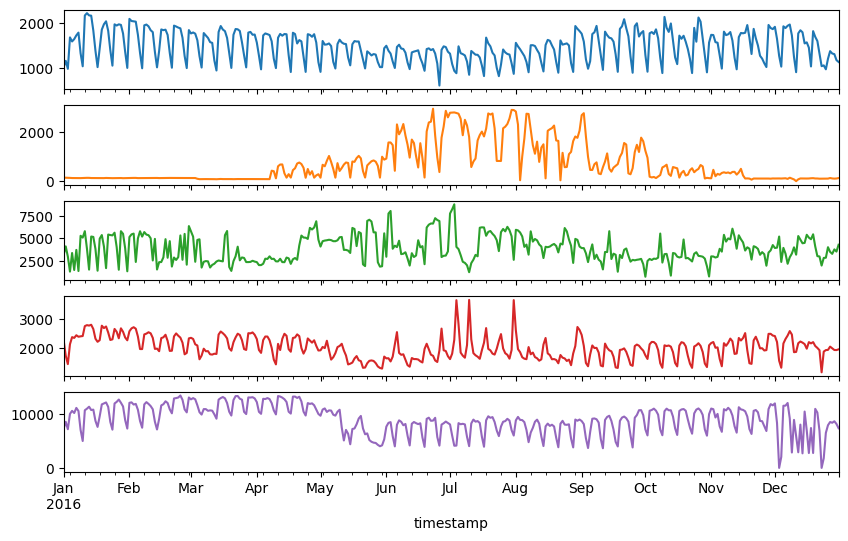

In [3]:
series.plot(subplots=True, figsize=(10, 6) , legend=False);

# Series is dataframe and exog is dataframe

In [4]:
# Series is dataframe and exog is dataframe
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train, exog=exog_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_1 = forecaster.predict(steps=5, exog=exog_val)
predictions_1

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:00:28

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


# Series is dataframe and exog is dictionary

In [5]:
# Series is dataframe and exog is dictionary
# ==============================================================================
exog_train_dict = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_2 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_2

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:00:35 
Last fit date: 2024-0

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


In [6]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)

# Series is dictionary and exog is dictionary

In [7]:
# Series is dictionary and exog is dictionary
# ==============================================================================
series_train_dict = series_train.to_dict('series')
series_val_dict   = series_val.to_dict('series')
series_test_dict  = series_test.to_dict('series')
exog_train_dict = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train_dict, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_3 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_3

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:00:37 
Last fit date: 2024-0

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


In [8]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)
pd.testing.assert_frame_equal(predictions_1, predictions_3)

# Series is dataframe with series of different lengths (filled with NaNs) and exog is None

+ id_1000: serie completa de inicio a fin
+ id_1001: serie de inicio hasta la mitad
+ id_1002: serie de mitad hasta el final
+ id_1003: serie solo con dos intervalos 
+ id_1004: serie con un único intervalo en el medio

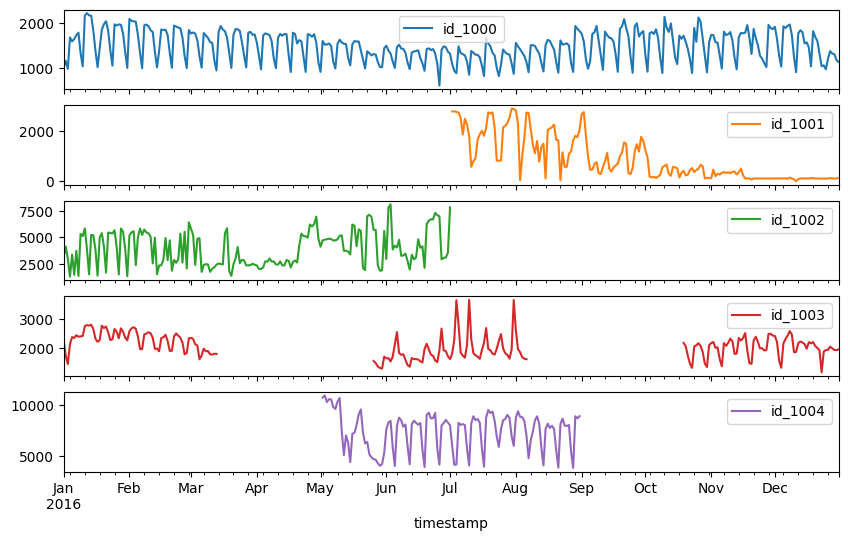

In [9]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_train = series.loc[: end_train, :].copy()
series_val   = series.loc[end_train:end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()

series.plot(subplots=True, figsize=(10, 6) , legend=True);

In [10]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-12-31'], 'id_1001': ['2016-01-01', '2016-12-31'], 'id_1002': ['2016-01-01', '2016-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:00:50 
Last fit date: 2024-03-30 13:00:50 
Skforecast version: 0.12.0 
Python version: 3.11.5 
Forecaste

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


In [11]:
print('Predictions')
print('------------')
predictions_5 = forecaster.predict(steps=5, levels=['id_1000'])
predictions_5

Predictions
------------


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [12]:
print('Predictions')
print('------------')
predictions_6 = forecaster.predict(steps=5, levels=['id_1004'])
predictions_6

Predictions
------------


,id_1004
2016-09-01,8872.845743
2016-09-02,8211.528184
2016-09-03,5673.015082
2016-09-04,4063.923527
2016-09-05,8608.514987


In [13]:
print('Predictions')
print('------------')
predictions_7 = forecaster.predict(steps=5, levels=['id_1000', 'id_1004'])
predictions_7

Predictions
------------


c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:1284: IgnoredArgumentWarning: Only series whose last window ends at the same index can be predicted together. Series that not reach the maximum index, '2016-12-31 00:00:00', are excluded from prediction: {'id_1004'}. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [14]:
print('Predictions')
print('------------')
predictions_8 = forecaster.predict(steps=5, levels=None)
predictions_8

Predictions
------------


,id_1000,id_1001,id_1003
2017-01-01,1052.310058,119.732235,2046.682242
2017-01-02,1348.389279,114.110698,2038.022302
2017-01-03,1455.782936,113.864170,2047.049785
2017-01-04,1415.239620,105.604602,1965.499059
2017-01-05,1398.959955,112.320310,1834.262846


In [15]:
pd.testing.assert_series_equal(predictions_8['id_1000'], predictions_7['id_1000'])

# Series is dictionaty with series of different lengths and exog is None

id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


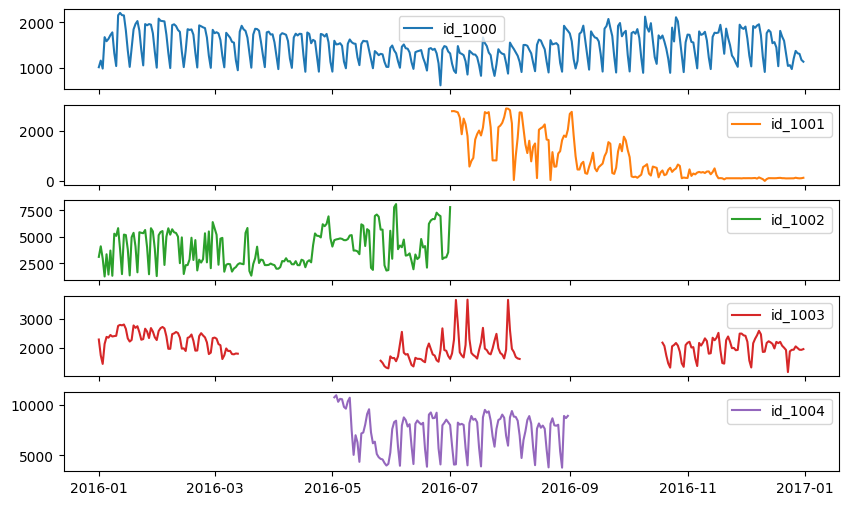

In [16]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
series_dict = {col: series_dict[col].asfreq("D") for col in series_dict.keys()}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()

In [17]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_9 = forecaster.predict(steps=5)
predictions_9

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-12-31'], 'id_1001': ['2016-07-02', '2016-12-31'], 'id_1002': ['2016-01-01', '2016-07-01'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:00:58 
Last fit date: 2024-03-30 13:00:58 
Skforecast version: 0.12.0 
Python version: 3.11.5 
Forecaste

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


,id_1000,id_1001,id_1003
2017-01-01,1052.310058,119.732235,2046.682242
2017-01-02,1348.389279,114.110698,2038.022302
2017-01-03,1455.782936,113.864170,2047.049785
2017-01-04,1415.239620,105.604602,1965.499059
2017-01-05,1398.959955,112.320310,1834.262846


In [18]:
pd.testing.assert_frame_equal(predictions_8, predictions_9)

# Series is dictionary with series of different lengths and exog is heterogeneous dictionary

id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=220, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=None
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


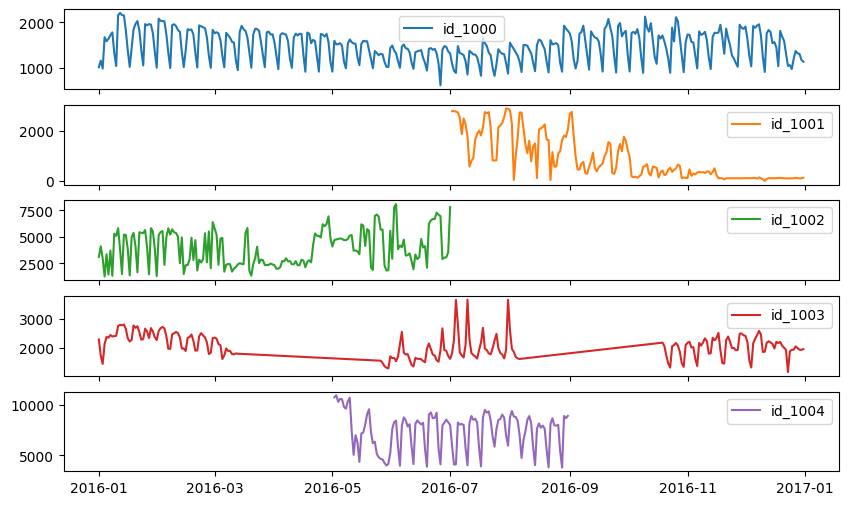

In [19]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
series_dict_train = {k : v.loc[: end_train].copy() for k, v in series_dict.items()}
series_dict_val   = {k : v.loc[end_train:end_validation].copy() for k, v in series_dict.items()}
series_dict_test  = {k : v.loc[end_validation:].copy() for k, v in series_dict.items()}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()


exog_train_dict = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}
exog_train_dict['id_1000'] = exog_train_dict['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_train_dict['id_1001'] = exog_train_dict['id_1001'].drop(columns=['cos_day_of_week'])
exog_val_dict['id_1000']   = exog_val_dict['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_val_dict['id_1001']   = exog_val_dict['id_1001'].drop(columns=['cos_day_of_week'])
exog_test_dict['id_1000']  = exog_test_dict['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_test_dict['id_1001']  = exog_test_dict['id_1001'].drop(columns=['cos_day_of_week'])

In [20]:
# Series is dataframe and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'ordinal'
            )
forecaster.fit(series=series_train_dict, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_10 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_10

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['air_temperature', 'wind_speed', 'sin_day_of_week', 'cos_day_of_week'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-30 13:01:02 
Last fit date: 2024-

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExogWarning: {'cos_day_of_week', 'sin_day_of_week'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1001'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.w

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1295.688799,2708.674620,4782.105699,2825.636469,7354.208890
2016-08-02,1476.869780,2552.956612,5288.290065,2296.480578,8723.957689
2016-08-03,1432.629648,2400.914433,5169.295773,2096.785368,9365.043600
2016-08-04,1372.899558,2416.142975,5202.936325,2004.178234,10038.891044
2016-08-05,1340.233155,2327.367259,5297.652085,1868.114938,10537.242005


id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=220, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=None
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


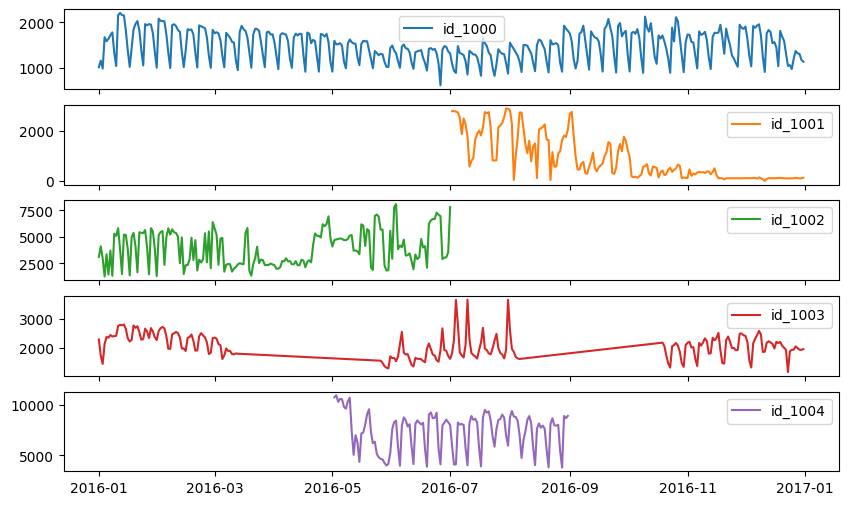

In [21]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
#series_dict = {col: series_dict[col].asfreq("D") for col in series_dict.keys()}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()

In [22]:
# Fin minimum and maximum index among all values of the dictionary
# ==============================================================================
min_index = min([v.index[0] for v in series_dict.values()])
max_index = max([v.index[-1] for v in series_dict.values()])
frequency = set([v.index.freqstr for v in series_dict.values() if v.index.freqstr is not None])

# checks if all series have the same frequency!!!!!!!!!!!!!!!
frequency = list(frequency)[0]
span_index = pd.date_range(min_index, max_index, freq=frequency)

print(f"min_index: {min_index}")
print(f"max_index: {max_index}")
print(f"frequency: {frequency}")

span_index


min_index: 2016-01-01 00:00:00
max_index: 2016-12-31 00:00:00
frequency: D


DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=366, freq='D')

In [23]:
# from skforecast.model_selection import _create_backtesting_folds
# y = pd.Series(np.arange(100))
# y.index = pd.date_range(start='2022-01-01', periods=100, freq='D')
# window_size = 3
# initial_train_size = 70
# test_size = 10
# refit = False

# folds = _create_backtesting_folds(
#             data                  = y,
#             window_size           = window_size,
#             initial_train_size    = initial_train_size,
#             test_size             = test_size,
#             externally_fitted     = False,
#             refit                 = refit,
#             fixed_train_size      = False,
#             gap                   = 0,
#             allow_incomplete_fold = True,
#             return_all_indexes    = False,
#             verbose               = True
#         )

# folds[0]

In [24]:
# from typing import Union, Optional, Tuple  

# def _extract_data_folds_multiseries(
#     series: Union[pd.Series, pd.DataFrame, dict],
#     folds: list,
#     exog: Optional[Union[pd.Series, pd.DataFrame, dict]] = None,
#     span_index: Optional[Union[pd.DatetimeIndex, pd.RangeIndex]] = None,
#     dropna_last_window: bool = False,
# ) -> Tuple[
#     Union[pd.Series, pd.DataFrame, dict],
#     pd.DataFrame,
#     list,
#     Union[pd.Series, pd.DataFrame, dict],
#     Union[pd.DatetimeIndex, pd.RangeIndex],
#     list,
# ]:
#     """
#     Select the data from series and exog that corresponds to each fold created using the
#     skforecast.model_selection._create_backtesting_folds function.

#     Parameters
#     ----------
#     series: pd.Series, pd.DataFrame, dict
#         Time series.
#     folds: list
#         Folds created using the skforecast.model_selection._create_backtesting_folds
#         function.
#     exog: pd.Series, pd.DataFrame, dict
#         Exogenous variable.
#     span_index: pd.DatetimeIndex, pd.RangeIndex
#         Full index from the minimum to the maximum index among all series.

#     Yield
#     -------
#     series_train: pd.Series, pd.DataFrame, dict
#         Time series corresponding to the training set of the fold.
#     series_last_window: pd.Series, pd.DataFrame, dict
#         Time series corresponding to the last window of the fold.
#     levels_last_window: list
#         Levels of the time series present to the last window of the fold.
#     exog_train: pd.Series, pd.DataFrame, dict
#         Exogenous variable corresponding to the training set of the fold.
#     exog_test: pd.Series, pd.DataFrame, dict
#         Exogenous variable corresponding to the test set of the fold.
#     span_index: pd.DatetimeIndex, pd.RangeIndex
#         Full index from the minimum to the maximum index among all series.
#     fold: list
#         Fold created using the skforecast.model_selection._create_backtesting_folds

#     """
#     for fold in folds:
#         train_iloc_start = fold[0][0]
#         train_iloc_end = fold[0][1]
#         last_window_iloc_start = fold[1][0]
#         last_window_iloc_end = fold[1][1]
#         test_iloc_start = fold[2][0]
#         test_iloc_end = fold[2][1]

#         logger.debug(
#             f"\n"
#             f"Train fold       : {train_iloc_start} - {train_iloc_end}\n"
#             f"Last window fold : {last_window_iloc_start} - {last_window_iloc_end}\n"
#             f"Test fold        : {test_iloc_start} - {test_iloc_end}"
#         )

#         if isinstance(series, dict) or isinstance(exog, dict):
#             if span_index is None:
#                 if isinstance(series, dict):
#                     min_index = min([v.index[0] for v in series.values()])
#                     max_index = max([v.index[-1] for v in series.values()])
#                     # All series must have the same frequency
#                     frequency = series[list(series.keys())[0]].index.freqstr
#                     span_index = pd.date_range(
#                         start=min_index, end=max_index, freq=frequency
#                     )
#                 else:
#                     span_index = series.index

#             train_loc_start = span_index[train_iloc_start]
#             train_loc_end = span_index[train_iloc_end]
#             last_window_loc_start = span_index[last_window_iloc_start]
#             last_window_loc_end = span_index[last_window_iloc_end]
#             test_loc_start = span_index[test_iloc_start]
#             test_loc_end = span_index[test_iloc_end]

#             logger.debug(
#                 f"\n"
#                 f"Train fold       : {train_loc_start} - {train_loc_end}\n"
#                 f"Last window fold : {last_window_loc_start} - {last_window_loc_end}\n"
#                 f"Test fold        : {test_loc_start} - {test_loc_end}"
#             )

#         if isinstance(series, pd.DataFrame):
#             series_train = series.iloc[train_iloc_start:train_iloc_end,]
#             series_last_window = series.iloc[
#                 last_window_iloc_start:last_window_iloc_end,
#             ]
#         else:
#             series_train = {
#                 k: v.loc[train_loc_start:train_loc_end] for k, v in series.items()
#             }
#             series_train = {k: v for k, v in series_train.items() if len(v) > 0}
#             series_last_window = {
#                 k: v.loc[last_window_loc_start:last_window_loc_end]
#                 for k, v in series.items()
#             }
#             series_last_window = pd.DataFrame(series_last_window)

#         if dropna_last_window:
#             series_last_window = series_last_window.dropna(axis=1, how="any")
#             # TODO: add the option to drop the series without minimum non NaN values.
#             # Similar to how pandas does in the rolling window function.
#         levels_last_window = list(series_last_window.columns)

#         if exog is not None:
#             if isinstance(exog, (pd.Series, pd.DataFrame)):
#                 exog_train = exog.iloc[train_iloc_start:train_iloc_end, :]
#                 exog_test = exog.iloc[test_iloc_start:test_iloc_end, :]
#             else:
#                 exog_train = {
#                     k: v.loc[train_loc_start:train_loc_end, :] for k, v in exog.items()
#                 }
#                 exog_train = {k: v for k, v in exog_train.items() if len(v) > 0}
#                 exog_test = {
#                     k: v.loc[test_loc_start:test_loc_end, :] for k, v in exog.items()
#                 }
#                 exog_test = {k: v for k, v in exog_test.items() if len(v) > 0}
#         else:
#             exog_train = None
#             exog_test = None

#         yield series_train, series_last_window, levels_last_window, exog_train, exog_test, span_index, fold

In [25]:
# from skforecast.model_selection_multiseries.model_selection_multiseries import _extract_data_fold_multiseries

# import logging
# from skforecast.model_selection_multiseries import model_selection_multiseries
# logger = logging.getLogger(model_selection_multiseries.__name__)
# logger.setLevel(logging.DEBUG)

# folds = [
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
# ]

# data_folds = _extract_data_folds_multiseries(series=series_dict, folds=folds, exog=exog, span_index=None)
# data_folds

## Backtesting: series is dataframe and exog is None

In [26]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series=True
            )

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = 50,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 1,
                                           verbose               = True,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 50
Number of observations used for backtesting: 316
    Number of folds: 14
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-02-19 00:00:00  (n=50)
    Validation: 2016-02-20 00:00:00 -- 2016-03-14 00:00:00  (n=24)
Fold: 1
    Training:   2016-01-25 00:00:00 -- 2016-03-14 00:00:00  (n=50)
    Validation: 2016-03-15 00:00:00 -- 2016-04-07 00:00:00  (n=24)
Fold: 2
    Training:   2016-02-18 00:00:00 -- 2016-04-07 00:00:00  (n=50)
    Validation: 2016-04-08 00:00:00 -- 2016-05-01 00:00:00  (n=24)
Fold: 3
    Training:   2016-03-13 00:00:00 -- 2016-05-01 00:00:00  (n=50)
    Validation: 2016-05-02 00:00:00 -- 2016-05-25 00:00:00  (n=24)
Fold: 4
    Training:   2016-04-06 00:00:00 -- 2016-05-25 00:00:00  (n=50)


  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,185.953235,5.857820e+04
1,id_1001,472.346257,4.301278e+05
2,id_1002,1510.813225,3.629893e+06
3,id_1003,349.023566,2.384887e+05
4,id_1004,1001.115655,1.715415e+06



Backtest predictions


,id_1000,id_1002,id_1003,id_1004,id_1001
2016-02-20,1212.956697,3223.414080,2126.700240,NaN,NaN
2016-02-21,1100.710860,3595.415366,2139.723208,NaN,NaN
2016-02-22,1354.913153,2788.744848,2222.261651,NaN,NaN
2016-02-23,1573.521251,3649.466675,2242.896263,NaN,NaN


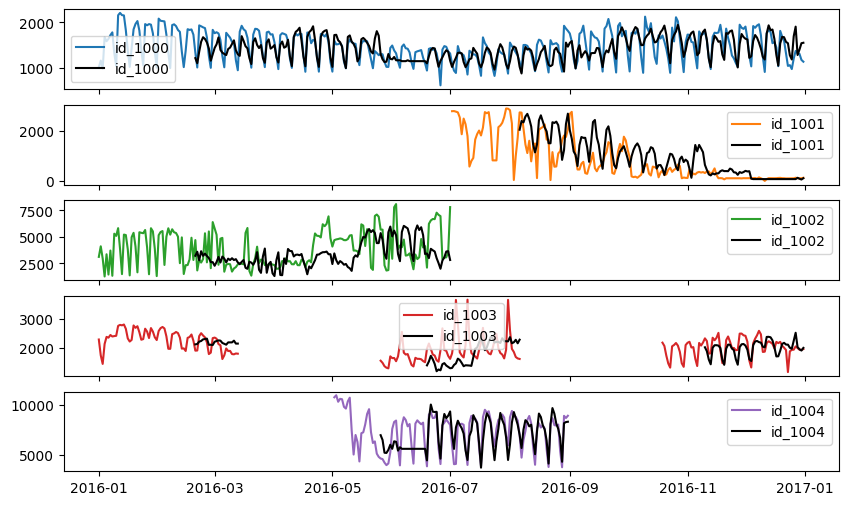

In [27]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

## Backtesting: series is dict and exog is None

id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


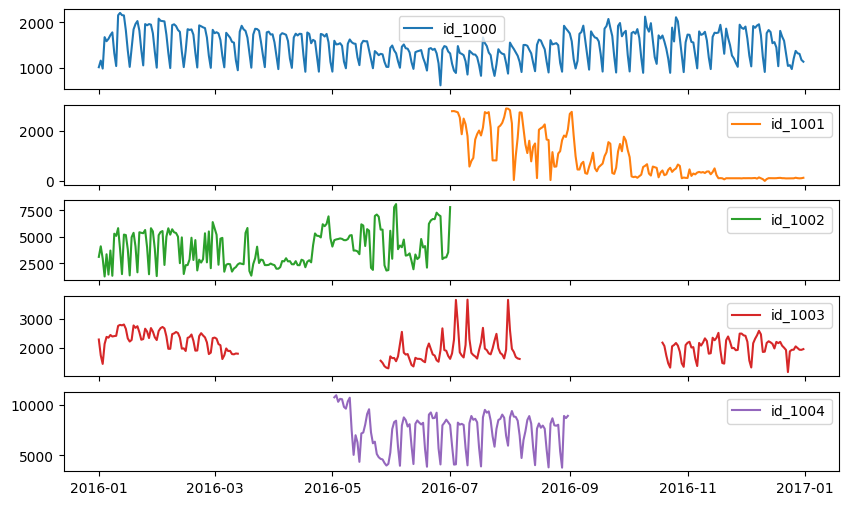

In [28]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
series_dict = {col: series_dict[col].asfreq("D") for col in series_dict.keys()}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()

  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,185.953235,5.857820e+04
1,id_1001,472.346257,4.301278e+05
2,id_1002,1510.813225,3.629893e+06
3,id_1003,349.023566,2.384887e+05
4,id_1004,1001.115655,1.715415e+06



Backtest predictions


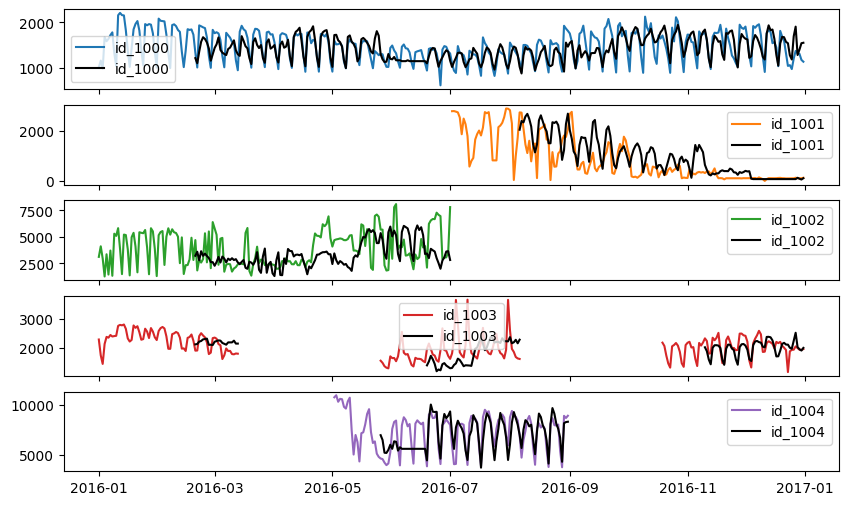

In [58]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series=True
            )

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series_dict,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = 50,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 1,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

In [41]:
backtest_predictions.isna().sum()

id_1000      0
id_1002      0
id_1003    146
dtype: int64

In [43]:
series_dict['id_1002']

timestamp
2016-01-01    3114.500198
2016-01-02    4110.000000
2016-01-03    2965.000000
2016-01-04    1269.500000
2016-01-05    3360.500000
                 ...     
2016-06-27    2907.000893
2016-06-28    3048.000793
2016-06-29    3072.000298
2016-06-30    3541.000694
2016-07-01    7802.001984
Freq: D, Name: id_1002, Length: 183, dtype: float64

In [45]:
missing_index = series_dict['id_1002'][series_dict['id_1002'].isna()].index
missing_index

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq='D')

In [46]:
missing_index.intersection(backtest_predictions.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [ ]:
levels_in_backtest_predictions = backtest_predictions.columns
for level in levels_in_backtest_predictions:
    missing_index = series[level][series[level].isna()].index
    missing_index = missing_index.intersection(backtest_predictions.index)
    backtest_predictions.loc[missing_index, level] = np.nan

In [47]:
level = 'id_1002'

predictions_level = pd.merge(
                series_dict[level],
                backtest_predictions[level],
                left_index  = True,
                right_index = True,
                how         = "outer",
                suffixes    = ("_true", "_pred"),
            ).dropna(axis=0, how="any")
predictions_level

,id_1002_true,id_1002_pred
2016-02-20,4697.000198,3223.414080
2016-02-21,1839.500694,3595.415366
2016-02-22,2851.999802,2788.744848
2016-02-23,2580.000397,3649.466675
2016-02-24,2902.500298,3214.605478
...,...,...
2016-06-27,2907.000893,2494.128375
2016-06-28,3048.000793,2471.714192
2016-06-29,3072.000298,2905.839781
2016-06-30,3541.000694,3079.993084


In [ ]:
backtest_predictions.isna().sum()

# Puntos a revisar

+ ¿Exog en el predict tiene que ser necesariamente un dataframe? Ahora mismo hay conflicto de tipos. Predict espera un exog del mismo tipo que en train, pero tiene un check que en predict solo permite dataframe o serie. Si el forecaster se entrena con dict falla.